In [1]:
# 완전연결층 Affine

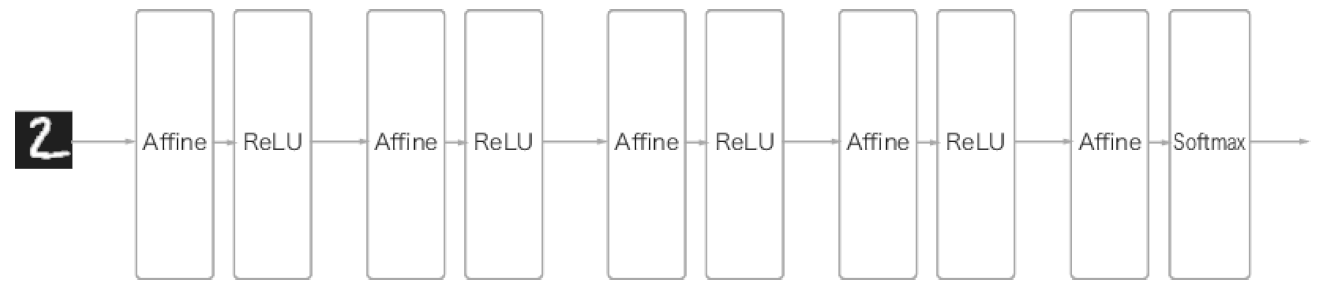

In [2]:
# CNN으로 연결된 층

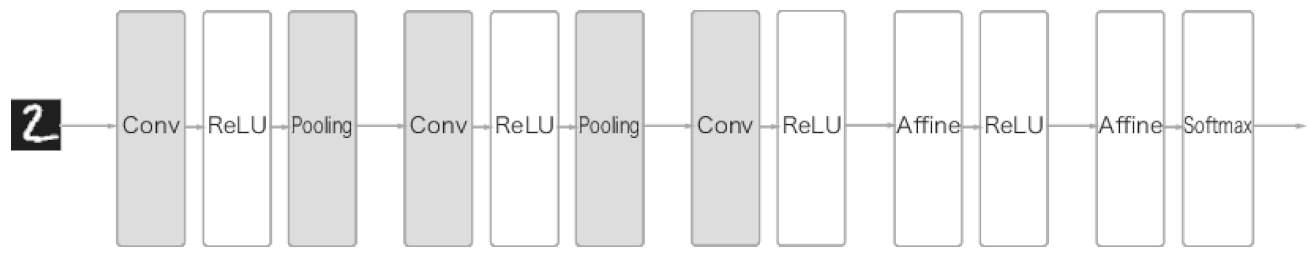

In [3]:
# conv-> 합성곱 연산 -> 필터 연산

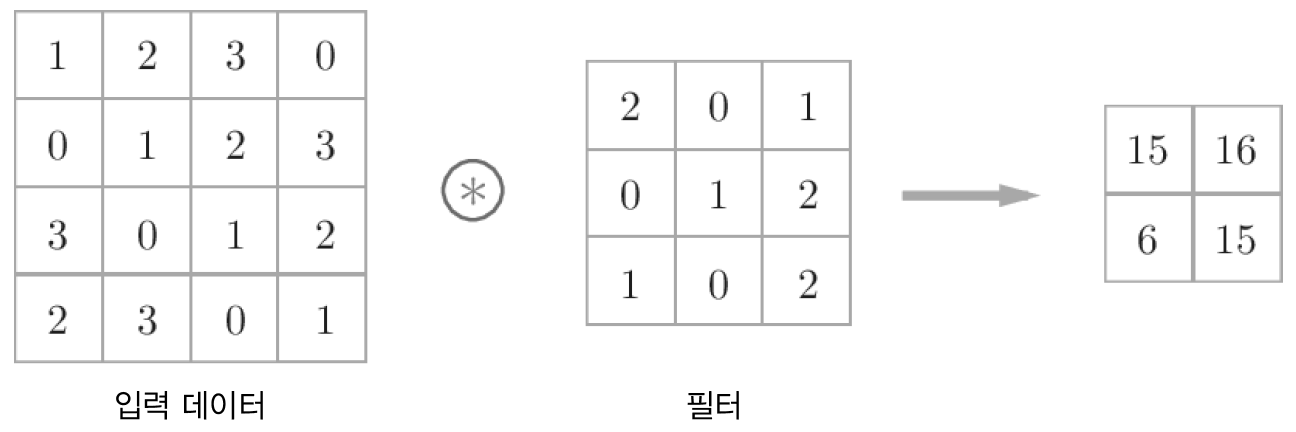

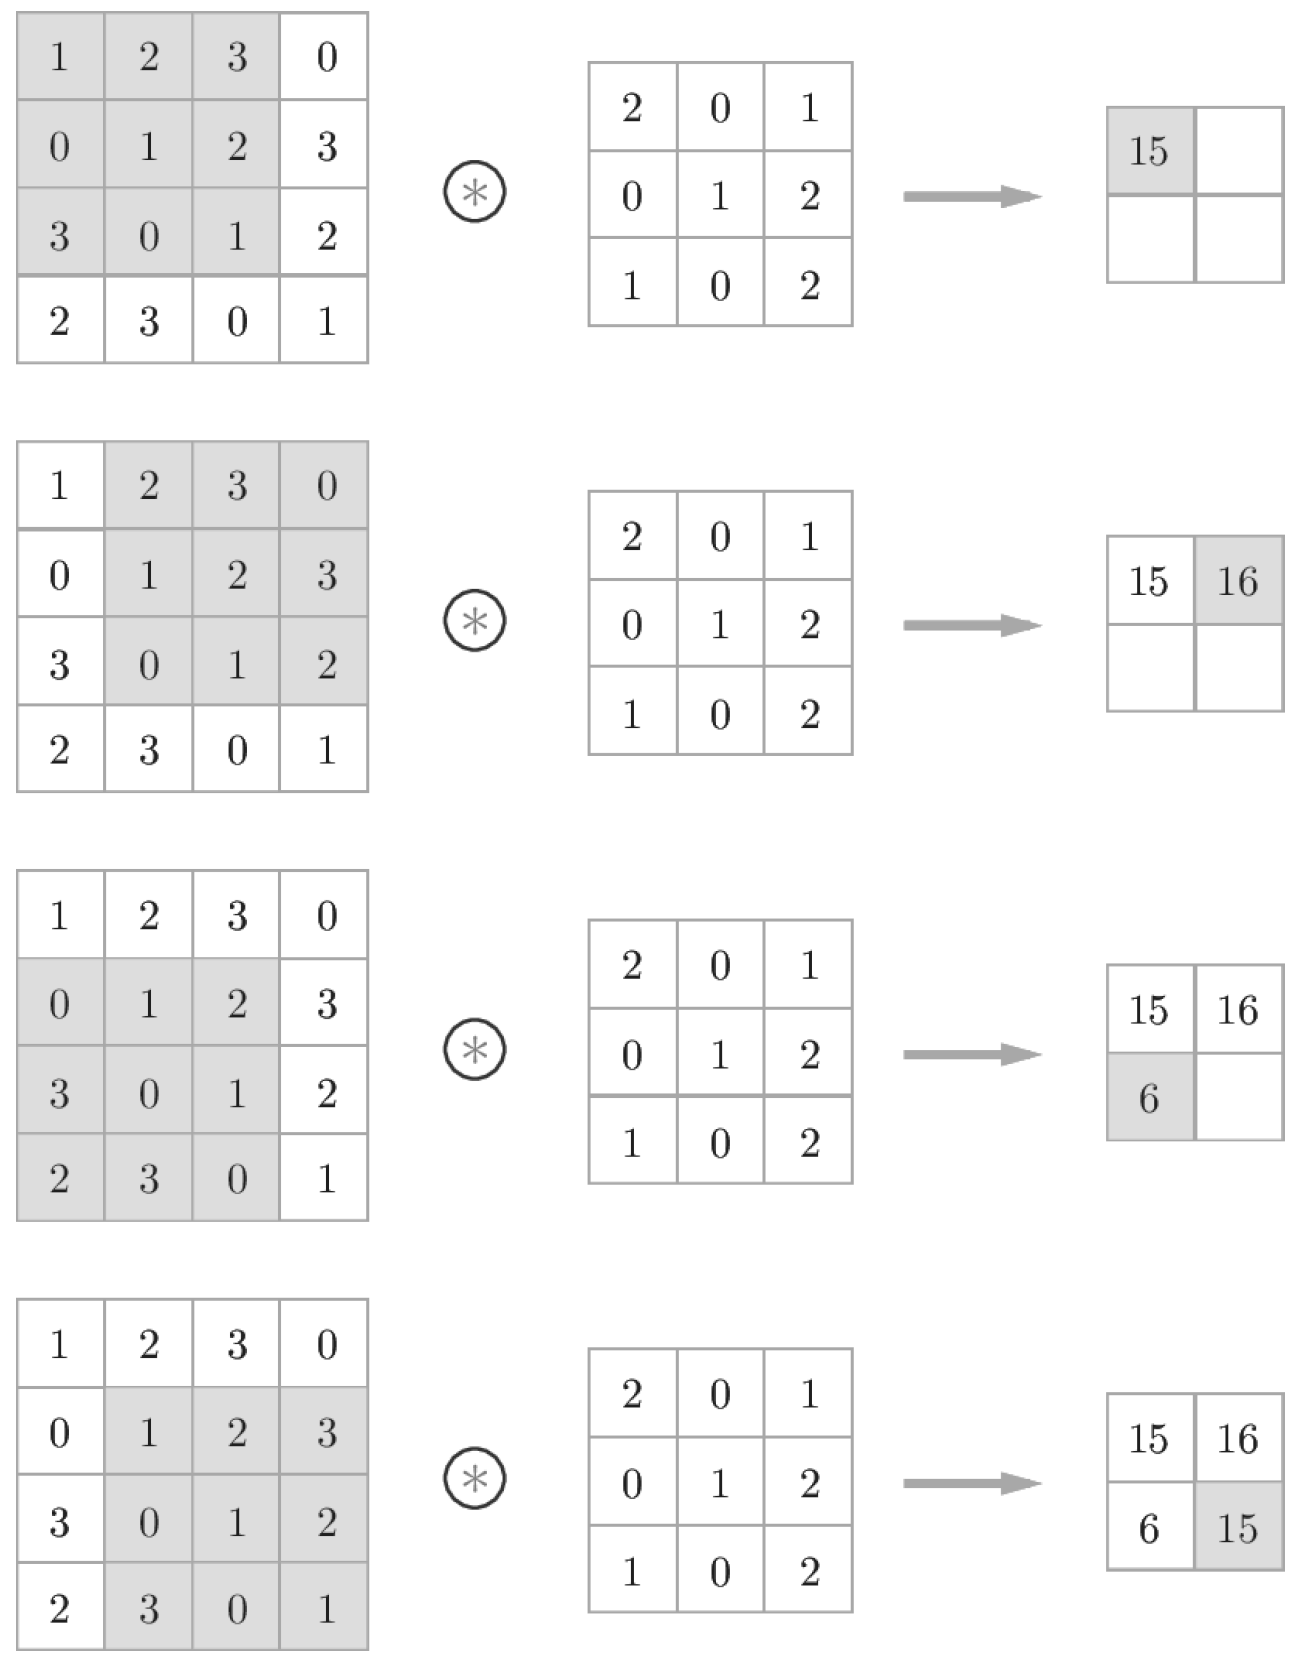

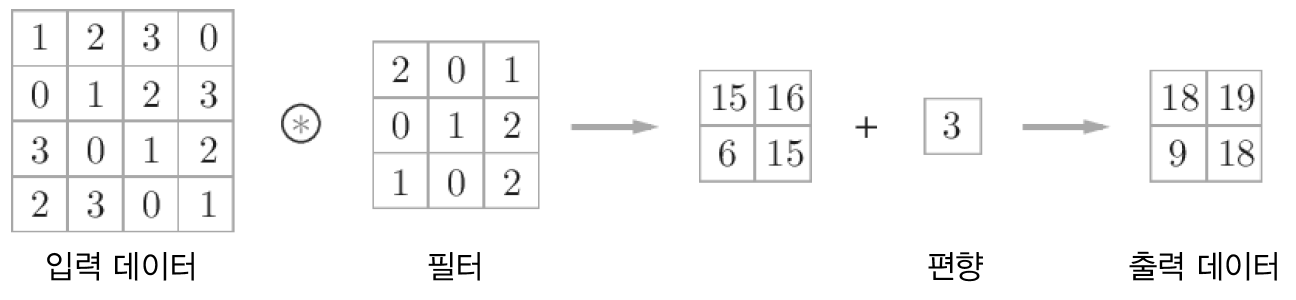

In [4]:
# 패딩  : 입력데이터 주변의 특정 값(0)으로 채우는 행위
# 패딩 1 적용

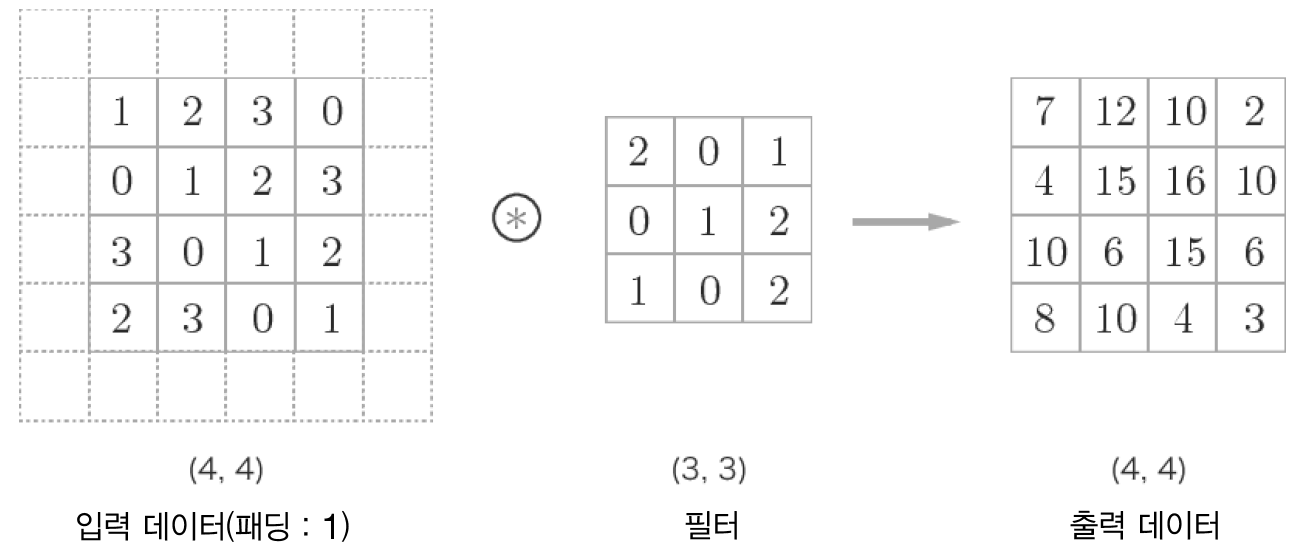

In [5]:
# 스트라이드 : 2

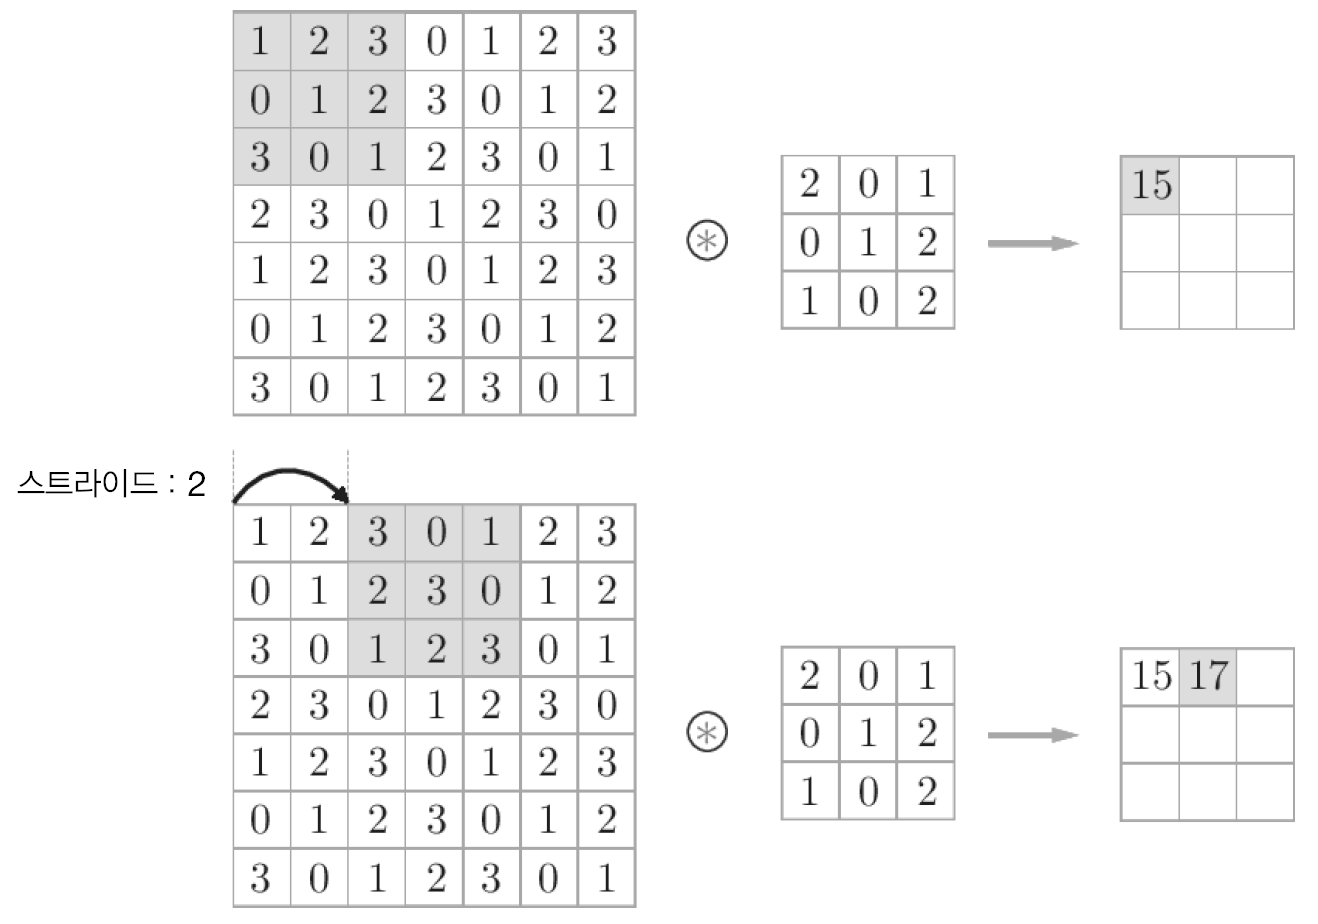

In [6]:
# 패딩을 크게하면 출력이 커지고  스트라이드를 크게 하면 출력이 작아진다.
# 입력 (H,W),  필터(FH, FW) 출력 (OH, OW) 패딩P  스트라이드를 S
# 출력의 크기 공식

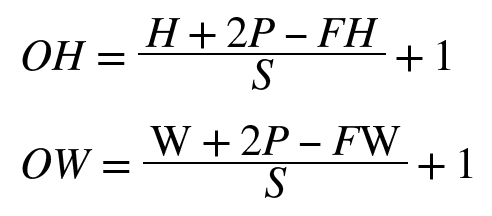

In [7]:
# 3차원 데이터의 합성곱 연산

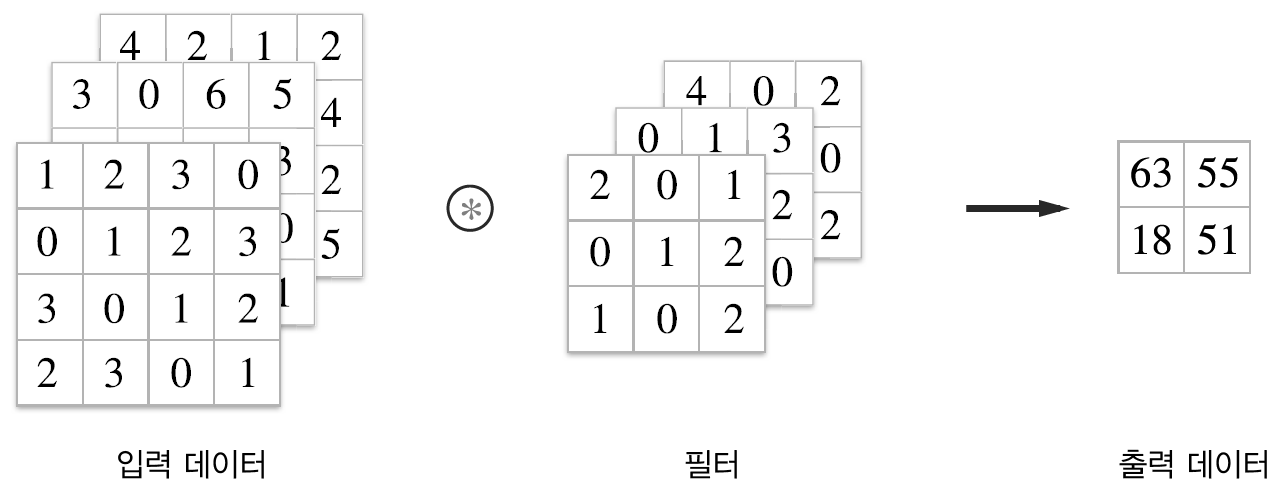

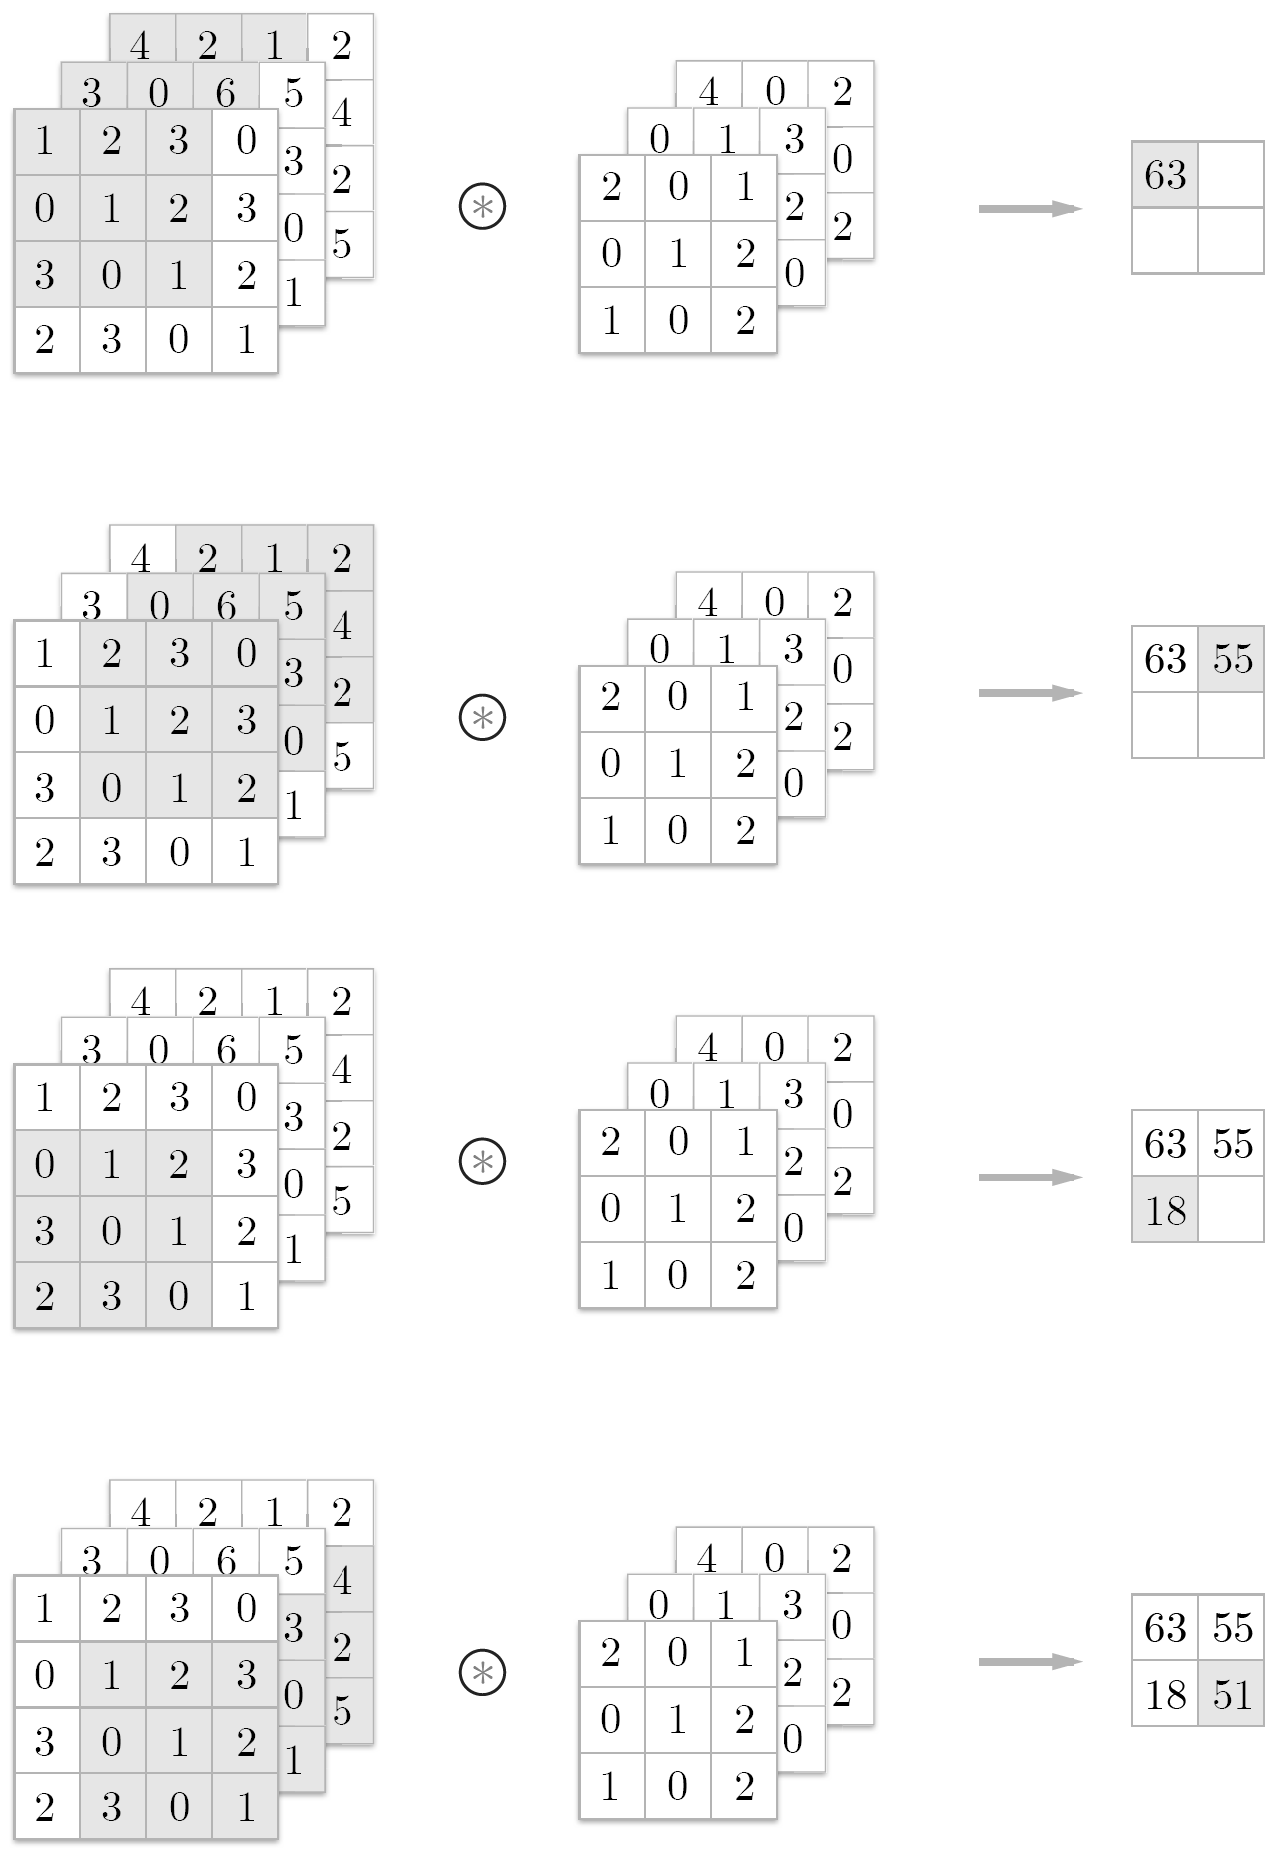

In [8]:
# 블럭단위로 시각화 또는 생각

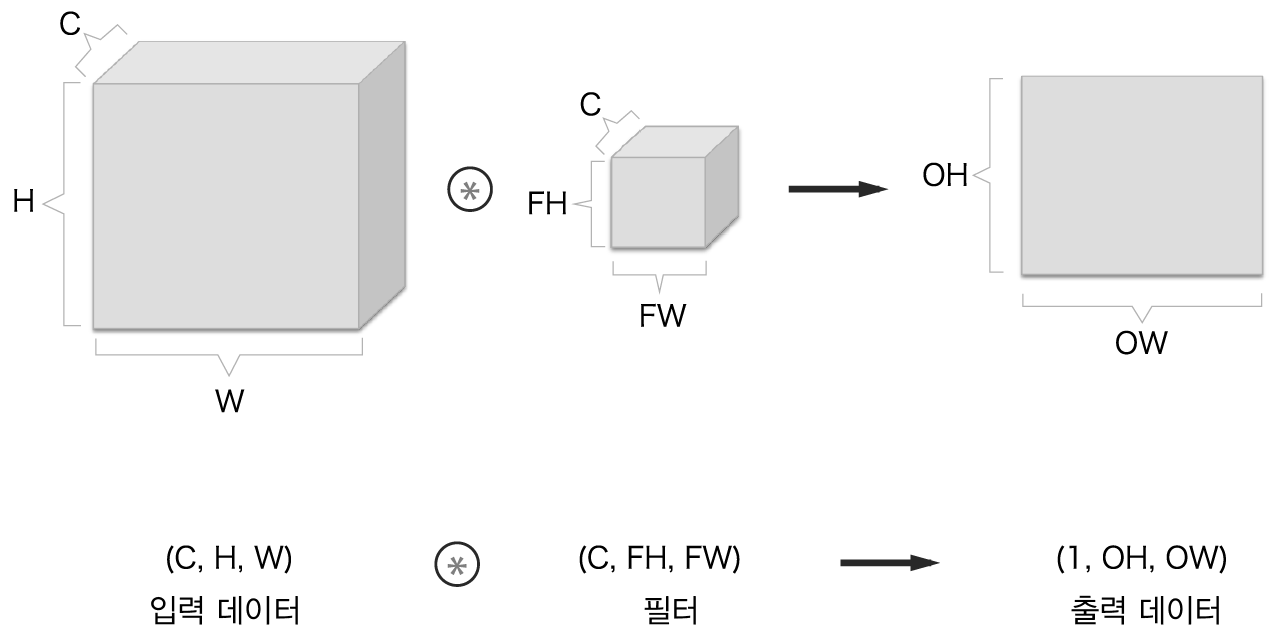

In [9]:
# 필터를 여러개 사용(특징을 잘 추출하기 위해서)

In [10]:
# 필터의 수를 고려.... (출력채널수, 입력 채널수, 높이 , 너비)  (20,3,5,5)

In [11]:
# 합성곱에서 편향을 추가한 모양

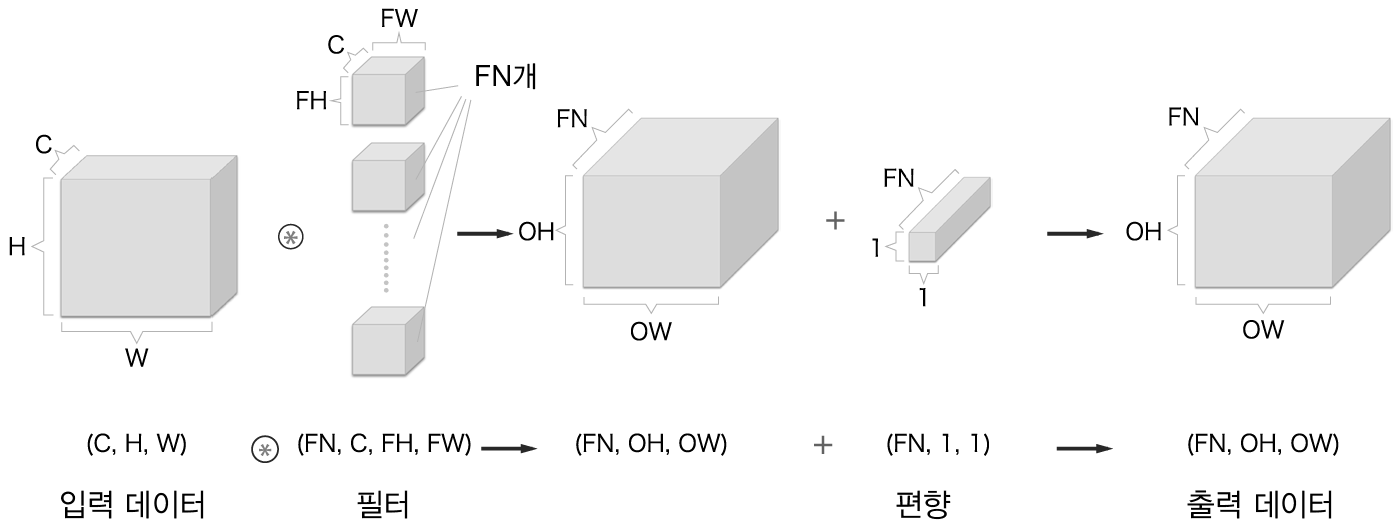

In [12]:
# 신경망에서는 배치처리를기본.... GPU:병렬연산을 지원

In [13]:
# 폴링 : 가로 세로방향의 공간을 축소
# 최대폴링

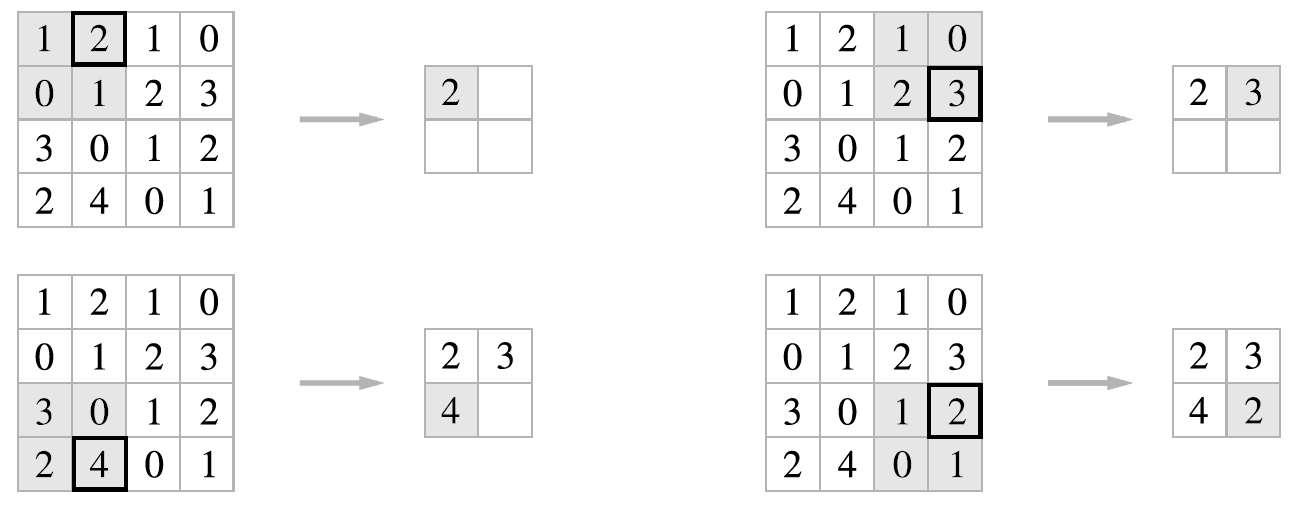

In [14]:
# 평균폴링 : 평균값을 취한다.
# 이미지쪽에서는 대부분 최대폴링을 사용
# 학습을 하지 않는다..(매개변수가 없음)
# 채널수는 변경 없음

In [15]:
# 합성곱 / 폴링 계층 구현

In [16]:
import numpy as np

In [17]:
x = np.random.rand(10,1,28,28)
x.shape

(10, 1, 28, 28)

In [18]:
x[0][0][0].shape

(28,)

In [19]:
# util함수 입력데이터를 필터링하기 좋게 전개하는 함수
# 3차원 입력 데이터를 2차원 행렬로 변경

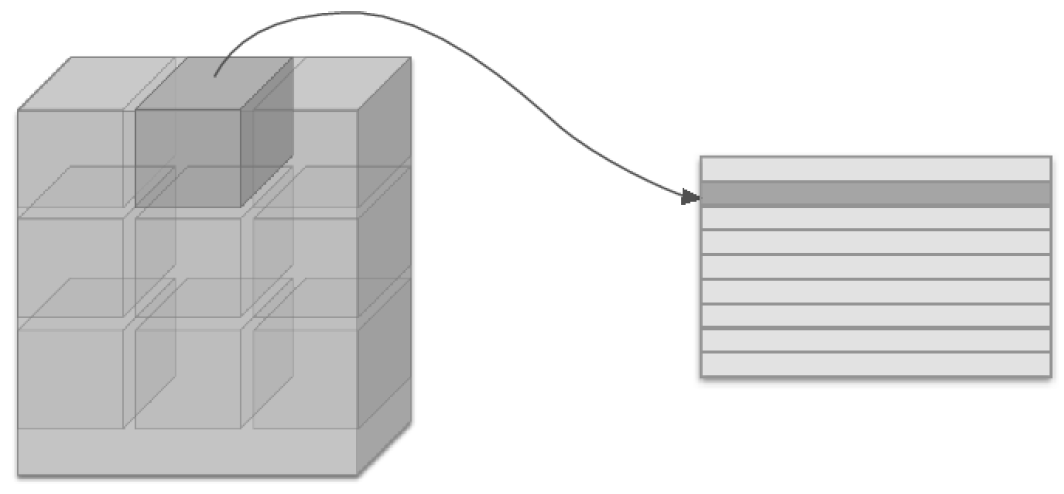

In [20]:
a = [1,2,3]
# 왼쪽으로 2개 오른쪽으로 3개 0으로 패딩
np.pad(a, (2,3),'constant',constant_values=0)

array([0, 0, 1, 2, 3, 0, 0, 0])

In [21]:
def im2col(input_data, filter_h, filter_w, stride=1,pad=0):
    '''
    input_data : 4차원(이미지수, 채널수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    
    returns : 2차원 배열    
    '''
    N,C,H,W =  input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    
    img = np.pad(input_data, [(0,0),(0,0),(pad,pad),(pad,pad)], 'constant',constant_values=0)
    col = np.zeros( (N,C, filter_h,filter_w,out_h,out_w) )
    
    for y in range(filter_h):
        y_max = y+stride*out_h
        for x in range(filter_w):
            x_max = x+stride*out_w
            col[:,:,y,x, :, :] = img[:,:,y:y_max:stride, x:x_max:stride]
    col = col.transpose(0,4,5,1,2,3).reshape(N*out_h*out_w,-1)
    return col    

In [22]:
x1 = np.random.rand(1,3,7,7) # 데이터 1, 채널수 3 높이 7 너비 7
col1 = im2col(x1,5,5)

In [23]:
col1.shape

(9, 75)

In [24]:
x2 = np.random.rand(10,3,7,7) # 데이터 1, 채널수 3 높이 7 너비 7
col2 = im2col(x2,5,5)
col2.shape

(90, 75)

In [25]:
# 필터의 원소수 : 채널이 3 5x5  : 3*5*5*

In [46]:
class Convolution:
    def __init__(self, w,b,stride=1,pad=0):
        self.w = w
        self.b = b
        self.stride = stride
        self.pad = pad
    def forward(self, x):
        FN,FC,FH,FW =  self.w.shape
        N,C,H,W =  x.shape
        out_h = (H + 2*self.pad - FH)//self.stride + 1
        out_w = (W + 2*self.pad - FW)//self.stride + 1
        
        col = im2col(x,FH,FW,self.stride,self.pad)
        col_w = self.w.reshape(-1,FN) # 필터전개
        out = np.dot(col, col_w) + self.b
        out = out.reshape(N, out_h, out_w,-1).transpose(0,3,1,2)
        return out    
    def backward(self,dout):
        N,C,H,W =  self.w.shape   
        

In [27]:
# 폴링계층

In [28]:
# 행렬의 최대값을 구하고 적절하게 reshape 

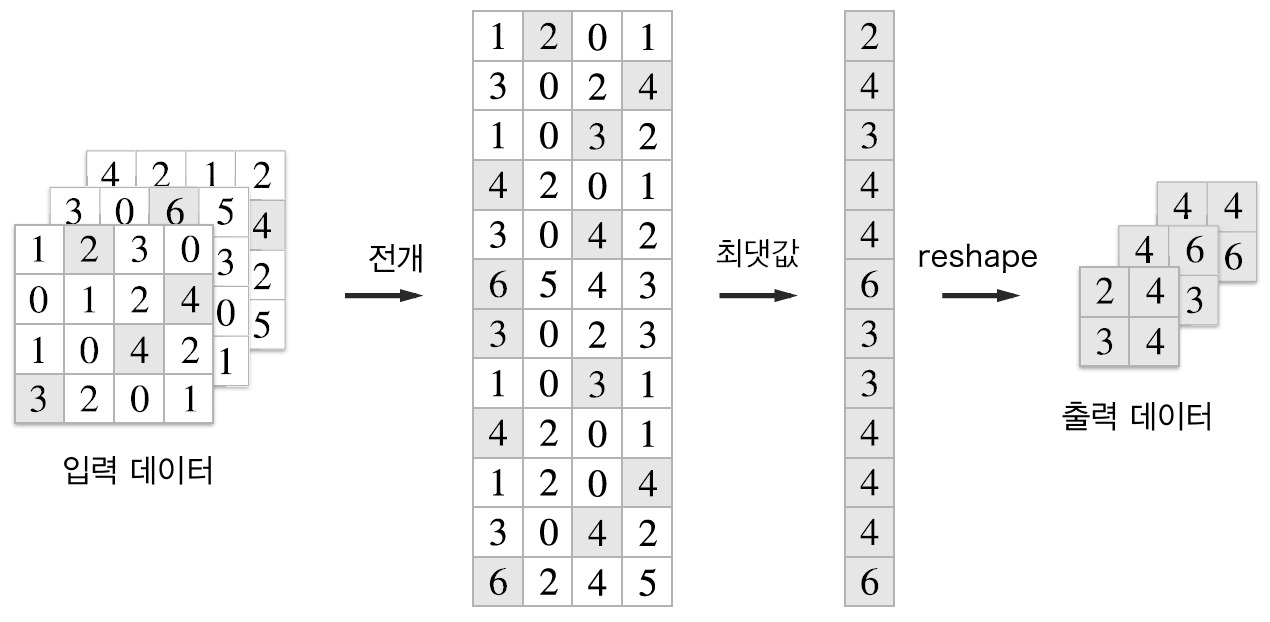

In [29]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
    def forward(self, x):
        N,C,H,W =  x.shape
        out_h = (H + 2*self.pad - self.pool_h)//self.stride + 1
        out_w = (W + 2*self.pad - self.pool_w)//self.stride + 1
        
#         out_h =  (1+(H-self.pool_h) / self.stride)
#         out_w =  (1+(W-self.pool_h) / self.stride)
        
#         out_h = (H + 2*self.pad - self.pool_h) // (self.stride-self.pool_h) + 1
#         out_w = (W + 2*self.pad - self.pool_w) // (self.stride-self.pool_w) + 1
        
        # 전개
        col = im2col(x, self.pool_h, self.pool_w,self.stride, self.pad)
        col = col.reshape(-1,self.pool_h*self.pool_w)
        
        # 최대값
        out = np.max(col, axis=1)
        
        # reshape
        out = out.reshape(N, out_h,out_w,C).transpose(0,3,1,2)
        return out     
    
    def backward(self,dout):
        return dout

In [30]:
# CNN 구현  C - R - P  - A - R -A -S

In [31]:
from collections import OrderedDict
from common import *

In [32]:
class SimpleConvNet:
    def __init__(self, input_dim = (1,28,28)
                 , conv_param = {
                     'filter_num' :30, 'filter_size':5,'pad':0,'stride':1}
                 ,hidden_size = 100, output_size=10, weight_init_std = 0.01
                ):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size+2*filter_pad) // filter_stride + 1
        pool_output_size = filter_num*(conv_output_size//2)*(conv_output_size//2)
        self.params = {}
        self.params['w1'] = weight_init_std * np.random.randn(filter_num,input_dim[0],filter_size,filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['w2'] = weight_init_std * np.random.randn(pool_output_size,hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['w3'] = weight_init_std * np.random.randn(hidden_size,output_size)
        self.params['b3'] = np.zeros(output_size)
        
        # layer 구성
        self.layers = OrderedDict()
        self.layers['conv1'] = Convolution(self.params['w1'],self.params['b1'],stride=filter_stride,pad=filter_pad)
        self.layers['relu1'] = Relu()
        self.layers['pool1'] = Pooling(pool_h=2, pool_w=2, stride=2, pad=0)        
        self.layers['affine1'] = Affine(self.params['w2'],self.params['b2'])
        self.layers['relu2'] = Relu()
        self.layers['affine2'] = Affine(self.params['w3'],self.params['b3'])
        self.last_layer = SoftmaxWithLoss()
    
    def predict(self, x):  # 추론(예측)
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y,t)
    
    def gradient(self,x,t):
        #순전파
        self.loss(x,t)
        
        #역전파
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout);
        
        # 결과 저장(각 레이어는 파라메터를 저장하고 있다)
        grads = {}
        grads['w1'] = self.layers['conv1'].dw
        grads['b1'] = self.layers['conv1'].db
        grads['w2'] = self.layers['affine1'].dw
        grads['b2'] = self.layers['affine1'].db
        grads['w3'] = self.layers['affine2'].dw
        grads['b3'] = self.layers['affine2'].db
        
        return grads     
         

In [40]:
# 데이터 가져오기
(x_train,y_train),(x_test,y_test) = loadMnist(nomalize = True, flatten = False, onehotEncording=True)

In [41]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((60000, 1, 28, 28), (60000, 10), (10000, 1, 28, 28), (10000, 10))

In [42]:
# 5000, 1000
x_train,y_train = x_train[:5000],y_train[:5000]
x_test,y_test = x_test[:1000],y_test[:1000]

In [43]:
network = SimpleConvNet()

In [44]:
# 배치사이즈, epochs, optimizer 

In [47]:
from tqdm import tqdm
iters_num = 1000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 5000   # 미니배치 크기
learning_rate = 0.001

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in tqdm(range(iters_num)):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = y_train[batch_mask]
    
    # 오차역전파기법으로 기울기를 구한다
    print(x_batch.shape)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('w1', 'b1', 'w2', 'b2','w3','b3'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc , train loss| " + str(train_acc) + ", " + str(test_acc)+","+str(loss) )

  0%|                                                                                                                  | 0/1000 [00:00<?, ?it/s]

(5000, 1, 28, 28)


  0%|                                                                                                                  | 0/1000 [00:04<?, ?it/s]


AttributeError: 'Pooling' object has no attribute 'backward'